In [1]:
import dash
# import dash_auth
# from users import USERNAME_PASSWORD_PAIRS
from dash import dcc
from dash import html
import plotly
import dash_bootstrap_components as dbc
# import dash_daq as dq
from jupyter_dash import JupyterDash
from dash import Dash
import pandas as pd  
import joblib
import base64, io, os
from dash import  dash_table
import dash
import pandas as pd
from dash import dash_table
import pickle
from dash.dependencies import Input, Output, State, ALL, MATCH
import json
# from functools import reduce
from dash import Input, Output, State, html
from tqdm.notebook import trange, tqdm
import pickle
import numpy as np
import pandas as pd
# from cryptography.fernet import Fernet
import json
import io, base64, os
import pandas as pd
import datetime
import time
import re
import plotly.express as px
import plotly.graph_objects as go
from dash_canvas.utils import array_to_data_url

import geopandas
import tifffile as tiff
import cv2
import matplotlib; matplotlib.rcParams['figure.dpi']=300
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathpretrain.utils import generate_tissue_mask
import scipy.ndimage as ndimage
from skimage.util import compare_images
from skimage.measure import regionprops_table
from skimage import exposure
import tempfile
import matplotlib.image as mpimg
from skimage import data, draw
from io import BytesIO
import copy
from matplotlib.colors import Normalize as Colors_Normalize
# from scipy import ndimage

In [2]:
with open("./data/match_dict.pkl", "rb") as file:
    match_dict = pickle.load(file)

annotation_data = geopandas.read_file("./data/_SS12251_140745.geojson")
im_large = tiff.imread("./data/_SS12251_140745.svs")
im_medium = cv2.resize(im_large, None, fx=1/7, fy=1/7)
im_small = cv2.resize(im_large, None, fx=1/15, fy=1/15)

with open("./data/011320_002_N_HR_dict.pkl", "rb") as input_file:
    metal_data = pickle.load(input_file)

In [73]:
def crop_slide(image_array):
#     slide_file = list(filter(lambda x: match_dict[x] == imageId, match_dict))[0]    
    im_large=image_array#tifffile.imread(f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/metals/breast/new_slide_images_4_6_23/{slide_file}.svs")

    tissue_mask=generate_tissue_mask(im_large*5,compression=32.,threshold=240,kernel=10,gray_before_close=True) 
    compression=32
    
    # Metal image is only portion of slide
#     if (imageId == "092619_007_T_HER2"):    
        
#     if (imageId == "102720_003_T_TNBC"):
#         labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
#         lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
#         xmin,ymin,xmax,ymax=(lbl_table.iloc[1][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
#     else:  
    labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
    lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
    xmin,ymin,xmax,ymax=(lbl_table.iloc[0][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
    
    im_large_crop=im_large[xmin:xmax,ymin:ymax].copy()
    im_large_crop[~tissue_mask[xmin:xmax,ymin:ymax]]=255
    
    return im_large_crop, [[xmin, ymin], [xmax, ymax]], tissue_mask

def rescale_no_exposure(im_large_crop, metals_im_gray):
    im_large_crop_gray=cv2.cvtColor(im_large_crop,cv2.COLOR_RGB2GRAY) 
    compression_new=max(im_large_crop_gray.shape)/max(metals_im_gray.shape)        
    im_small_crop_gray=cv2.resize(im_large_crop_gray,None,fx=1/compression_new,fy=1/compression_new)
    im_small_crop=cv2.resize(im_large_crop,None,fx=1/compression_new,fy=1/compression_new)
    
    common_size=np.vstack([im_small_crop_gray.shape,metals_im_gray.shape]).max(0)

    im_small_crop_gray_pad=(np.ones(common_size)*np.nan)
    im_small_crop_gray_pad[:im_small_crop_gray.shape[0],:im_small_crop_gray.shape[1]]=im_small_crop_gray
    im_small_crop_gray_pad[np.isnan(im_small_crop_gray_pad)]=255

    metals_im_gray_pad=(np.ones(common_size)*np.nan)
    metals_im_gray_pad[:metals_im_gray.shape[0],:metals_im_gray.shape[1]]=metals_im_gray
    
    padding = common_size - im_small_crop_gray.shape
    
    return im_small_crop, im_small_crop_gray_pad, metals_im_gray_pad, compression_new, padding

def warp_metals(slide_x, slide_y, metals_x, metals_y):
    warped_metals=dict()   
    for _,(element,element_image) in dfs_new_df_co[['element','image']].iterrows():
        h, w = dfs_new_df_co['image'][0].shape
        metal_k_im_gray_pad = element_image

#         slide_x = [1009, 1065, 685, 773, 816, 630, 132, 12]
#         slide_y = [47, 2, 250, 267, 230, 867, 261, 379]
#         metals_x = [1037, 1078, 695, 785, 825, 622, 148, 16]
#         metals_y = [65, 17, 274, 300, 251, 859, 262, 352]
        points_src = []
        points_dst = []
        for i, p in enumerate(slide_x):
            points_dst.append([slide_x[i], slide_y[i]])
            points_src.append([metals_x[i], metals_y[i]])
        points_src = np.array(points_src)
        points_dst = np.array(points_dst)
        homo, status = cv2.findHomography(points_src, points_dst)
        warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (w, h))
    return warped_metals

In [98]:
im_large_crop, minmax_list, tissue_mask = crop_slide(im_large)


im_small_crop = cv2.resize(im_large_crop, None, fx=1/15, fy=1/15)
compression_annotation_tab = metal_data['metals']['Ca44'].shape[0]/im_large_crop.shape[0]
im_small_crop_annotation_tab = cv2.resize(im_large_crop, None, fx=compression_annotation_tab, fy=compression_annotation_tab)
im_small_crop_co = cv2.resize(im_large_crop, None, fx=compression_annotation_tab, fy=compression_annotation_tab)

hne_image = px.imshow(im_small_crop)
metal_image = px.imshow(np.log(metal_data['metals']['Ca44'])+10, color_continuous_scale='jet')

In [99]:
annotation_data['annot']=annotation_data['classification'].map(lambda x: x.get("name","none"))

gp2=annotation_data.copy()
gp2['geometry']=gp2['geometry'].scale(1/7,1/7,origin=(0,0))
gp2['coords'] = gp2['geometry'].apply(lambda x: x.representative_point().coords[:])
gp2['coords'] = [coords[0] for coords in gp2['coords']]

In [100]:
app = JupyterDash(__name__, 
                  external_stylesheets=[dbc.themes.SPACELAB], 
                 )

history_co_click = 0

xy_index = []

co_hne_x_list = []
co_hne_y_list = []

fig_hne_co = px.imshow(im_small_crop_co)
fig_hne_co.add_scatter(
    x=[],
    y=[],
    mode='markers',
    marker_color='black',
    marker_size=5,
)
fig_hne_co.update_layout(
    template='plotly_dark',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    width=700,#700,
    height=500,#500,
    margin={
        'l': 0,
        'r': 0,
        't': 0,
        'b': 0,
    }
)
fig_hne_co.update_xaxes(visible=False,)
fig_hne_co.update_yaxes(visible=False,)
fig_hne_co.update_coloraxes(showscale=False)



co_metal_x_list = []
co_metal_y_list = []

padded_rows_co = 1000
padded_columns_co = 1600
original_metal_image_co = metal_data['metals']['Ca44']
# rows_padding_co = max(0, padded_rows_co - original_metal_image_co.shape[0])
# columns_padding_co = max(0, padded_columns_co - original_metal_image_co.shape[1])
# top_pad_co = rows_padding_co // 2
# bottom_pad_co = rows_padding_co - top_pad_co
# left_pad_co = columns_padding_co // 2
# right_pad_co = columns_padding_co - left_pad_co
# padded_metal_image_co = np.pad(original_metal_image_co, ((top_pad_co, bottom_pad_co), (left_pad_co, right_pad_co)), mode='constant')
padded_metal_image_co = original_metal_image_co

cmap_jet = plt.cm.get_cmap('jet')
padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
padded_metal_image_co = np.log(padded_metal_image_co)+10
padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
replacement_color_to_white_co = np.array([1, 1, 1])
mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

fig_metal_co = px.imshow(padded_metal_image_rgb_co)
fig_metal_co.add_scatter(
    x=[],
    y=[],
    mode='markers+text',
    marker_color='black',
    marker_size=5,
    textposition='top center',
    textfont=dict(color='black'),
)
fig_metal_co.update_layout(
    template='plotly_dark',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    width=700,#700,
    height=500,#500,
    margin={
        'l': 0,
        'r': 0,
        't': 0,
        'b': 0,
    }
)
fig_metal_co.update_xaxes(visible=False,)
fig_metal_co.update_yaxes(visible=False,)
fig_metal_co.update_coloraxes(showscale=False)


original_df_co = pd.DataFrame({'index': xy_index, 
                               'hne x': co_hne_x_list, 'hne y': co_hne_y_list, 
                            'metals x': co_metal_x_list, 'metals y': co_metal_y_list, })
# update_df = pd.DataFrame({'index': xy_index, 
#                                'hne x': co_hne_x_list, 'hne y': co_hne_y_list, 
#                             'metals x': co_metal_x_list, 'metals y': co_metal_y_list, })
df_co = {'image': [], 'element': [],}
for one_metal in list(metal_data['metals'].keys()):
    df_co['image'].append(metal_data['metals'][one_metal])
    df_co['element'].append(one_metal)
dfs_new_df_co = pd.DataFrame(df_co)


white_image_cp = np.ones((100, 100, 3), dtype=np.uint8) * 255
white_fig_co = px.imshow(white_image)
white_fig_co.update_xaxes(visible=False,)
white_fig_co.update_yaxes(visible=False,)
white_fig_co.update_coloraxes(showscale=False)

xy_coords_table = dash_table.DataTable(
        id='datatable_coord_co',
        columns=[
            {"name": i, "id": i,} for i in original_df_co.columns
        ],
        data=original_df_co.to_dict('records'),
        editable=True, row_deletable=True,)

markdown_text_title = '''
# **Metals Demo**
'''

all_color_list = px.colors.qualitative.Dark24
result_df = pd.DataFrame({'type': [], 'metal': [], 
                              'mean': [], 'std': []})
newest_result_df = pd.DataFrame({'type': [], 'metal': [], 
                              'mean': [], 'std': []})

all_relayout_data = {'shapes': [], 'dragmode': ''}

type_to_color_dict = {'immune': all_color_list[0], 'tumor': all_color_list[1]}
color_to_type_dict = {all_color_list[0]: 'immune', all_color_list[1]: 'tumor'}

tab_Data_content = dbc.Card(
    dbc.CardBody(
        [
            html.P("This is Data tab", className="card-text"),
        ]
    ),
    className="mt-3",
)

image_no_axis_layout = go.Layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

hne_image = px.imshow(im_small_crop)
metal_image = px.imshow(np.log(metal_data['metals']['Ca44'])+10, color_continuous_scale='jet')

hne_image.update_layout(image_no_axis_layout)
metal_image.update_layout(image_no_axis_layout)
hne_image.update_layout(title=dict(text="H&E Image", x=0.5, y=0.95, xanchor='center'))

def path_to_indices(path, scale_factor):
    """From SVG path to numpy array of coordinates, each row being a (row, col) point
    """
    indices_str = [
        el.replace("M", "").replace("Z", "").split(",") for el in path.split("L")
    ]
    return np.rint(np.array(indices_str, dtype=float)*(1/scale_factor)).astype(np.int)

def path_to_mask(path, shape, scale_factor, padded_rows, padded_columns):
    path_work = path_to_indices(path, scale_factor)
    path_work[:, 0][path_work[:, 0] == padded_columns] = (padded_columns-1)
    path_work[:, 1][path_work[:, 1] == padded_rows] = (padded_rows-1)
    cols, rows = path_work.T
    rr, cc = draw.polygon(rows, cols)
    mask = np.zeros(shape, dtype=np.bool)
    mask[rr, cc] = True
    mask = ndimage.binary_fill_holes(mask)
    return mask

def update_metal_image(selected_metal, 
                       np_log, 
                      ):
    if np_log == 'With np log transform':
        original_metal_image = metal_data['metals'][selected_metal]
        cmap_jet = plt.cm.get_cmap('jet')
        original_metal_image[original_metal_image <= 0] = 0.000001
        original_metal_image = np.nan_to_num(original_metal_image, nan=0.000001)
        original_metal_image = np.log(original_metal_image)+10
        original_metal_image_normalized = (original_metal_image - original_metal_image.min()) / (original_metal_image.max() - original_metal_image.min())
        metal_image_data = cmap_jet(original_metal_image_normalized)
        metal_image_data = metal_image_data[:, :, :3]
        metal_image = px.imshow(metal_image_data)
    else:
        metal_image_data = metal_data['metals'][selected_metal]
        metal_image = px.imshow(metal_image_data, color_continuous_scale='jet')
        metal_image.layout.coloraxis.showscale = False
    metal_image.update_layout(image_no_axis_layout)
    metal_image.update_layout(title=dict(text="Metal Image - {}".format(selected_metal), x=0.5, y=0.95, xanchor='center'))
    return metal_image

tab_Visualization_content = dbc.Card(
    dbc.CardBody(
        [
            dbc.Row(
            [
                dbc.Col(dcc.Graph(id="hne_image", figure=hne_image,), 
                        width=6),
                dbc.Col(dcc.Graph(id="metal_image", figure=metal_image,),
                        width=6),
            ]
        ),
            dbc.Row([
                dcc.Dropdown(
                            id='metal_dropdown',
                            options=list(metal_data['metals'].keys()),
                            value='Ca44',
                            searchable=True, 
                            style={'width': '110px'},
                                ),
                dcc.Dropdown(
                            id='np_log_dropdown',
                            options=['With np log transform', 'Without np log transform'],
                            value='With np log transform',
                            style={'width': '300px'},
                                ),
            ], justify="end",),
        ]
    ),
    className="mt-3",
)

padded_rows = 1000
padded_columns = 1600

rows_padding = max(0, padded_rows - im_small_crop_annotation_tab.shape[0])
columns_padding = max(0, padded_columns - im_small_crop_annotation_tab.shape[1])
top_pad = rows_padding // 2
bottom_pad = rows_padding - top_pad
left_pad = columns_padding // 2
right_pad = columns_padding - left_pad
im_small_crop_annotation_tab = np.pad(
    im_small_crop_annotation_tab,
    ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)),
    mode='constant',
    constant_values=255,
)

def output_blank_hne(im_small_crop_annotation_tab):
    blank_figure_hne = go.Figure()

    blank_img_hne_width = im_small_crop_annotation_tab.shape[1]
    blank_img_hne_height = im_small_crop_annotation_tab.shape[0]
    scale_factor = 0.3

    blank_figure_hne.add_trace(
        go.Scatter(
            x=[0, blank_img_hne_width * scale_factor],
            y=[0, blank_img_hne_height * scale_factor],
            mode="markers",
            marker_opacity=0
        )
    )
    blank_figure_hne.update_xaxes(
        visible=False,
        range=[0, blank_img_hne_width * scale_factor]
    )
    blank_figure_hne.update_yaxes(
        visible=False,
        range=[0, blank_img_hne_height * scale_factor],
        scaleanchor="x",
    )
    blank_figure_hne.add_layout_image(
        dict(
            x=0,
            sizex=blank_img_hne_width * scale_factor,
            y=blank_img_hne_height * scale_factor,
            sizey=blank_img_hne_height * scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=array_to_data_url(im_small_crop_annotation_tab))
    )
    blank_figure_hne.update_layout(
        width=blank_img_hne_width * scale_factor,
        height=blank_img_hne_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
        title=dict(text="H&E Image", x=0.5, y=0.95, xanchor='center'),
    )
    return blank_figure_hne
blank_figure_hne = output_blank_hne(im_small_crop_annotation_tab)

padded_rows = 1000
padded_columns = 1600

original_metal_image = metal_data['metals']['Ca44']
rows_padding = max(0, padded_rows - original_metal_image.shape[0])
columns_padding = max(0, padded_columns - original_metal_image.shape[1])
top_pad = rows_padding // 2
bottom_pad = rows_padding - top_pad
left_pad = columns_padding // 2
right_pad = columns_padding - left_pad
padded_metal_image = np.pad(original_metal_image, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')

cmap_jet = plt.cm.get_cmap('jet')
padded_metal_image[padded_metal_image <= 0] = 0.000001
padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
padded_metal_image = np.log(padded_metal_image)+10
padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]

blank_figure = go.Figure()

blank_img_width = padded_columns
blank_img_height = padded_rows
scale_factor = 0.35

blank_figure.add_trace(
    go.Scatter(
        x=[0, blank_img_width * scale_factor],
        y=[0, blank_img_height * scale_factor],
        mode="markers",
        marker_opacity=0
    )
)

blank_figure.update_xaxes(
    visible=False,
    range=[0, blank_img_width * scale_factor]
)

blank_figure.update_yaxes(
    visible=False,
    range=[0, blank_img_height * scale_factor],
    scaleanchor="x",
)
    
blank_figure.add_layout_image(
    dict(
        x=0,
        sizex=blank_img_width * scale_factor,
        y=blank_img_height * scale_factor,
        sizey=blank_img_height * scale_factor,
        xref="x",
        yref="y",
        opacity=1.0,
        layer="below",
        sizing="stretch",
        source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
)

blank_figure.update_layout(
    width=blank_img_width * scale_factor,
    height=blank_img_height * scale_factor,
    margin={"l": 0, "r": 0, "t": 0, "b": 0},
)

image_annotation_card = dbc.Card(
    children = [dbc.CardHeader(html.H2("Annotation area")),
        dbc.CardBody(
            [
                dcc.Graph(
                    id="annotate_metal_image",
                    figure=blank_figure,
                    config={"modeBarButtonsToAdd": ["drawrect", "eraseshape", "drawclosedpath",], 
                            'modeBarButtonsToRemove': [
                                                        'zoom2d', 
                                                       'pan2d', 
                                                       'zoomIn2d', 'zoomOut2d', 
                                                        ]},
                ),
                dcc.Store(id='annotation_store', data=[]),
                dbc.Row([
                    html.Div("color map and metals: ", style={'font-weight': 'bold'}),
                ]),
                dbc.Row([
                    dcc.Dropdown(
                                id='annotation_colormap',
                                options=[{'label': 'viridis', 'value': 'viridis'}, 
                                         {'label': 'jet', 'value': 'jet'}, 
                                         {'label': 'plasma', 'value': 'plasma'}],
                                value='jet',
                                style={'width': '150px'}, 
                                    ),
                    dcc.Dropdown(
                                id='metal_dropdown_annotation',
                                options=list(metal_data['metals'].keys()),
                                value='Ca44',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),
                ], justify="start",),
                dbc.Row([
                    html.Div("vmin and vmax: ", style={'font-weight': 'bold'}),
                    dcc.RangeSlider(-20, 20, value=[0, 1], id="vmin_vmax_input",
                                    marks={
                                        -20: {'label': '-100', 'style': {'color': '#f50'}},
                                        0: {'label': '0', 'style': {'color': '#77b0b1'}},
                                        1: {'label': '1', 'style': {'color': '#77b0b1'}},
                                        20: {'label': '100', 'style': {'color': '#f50'}},
                                    },
                                    pushable=1,
                                    included=False,
                               tooltip={"placement": "bottom", "always_visible": True},
                                ),
                    ], justify="start",),
            ]
        ),
        dbc.CardFooter(
            [
                dcc.Markdown(
                    "To annotate the above image"
                    "rectangle .\n\n"
                    "**Choose metals**:"
                ),
                dbc.Row([
                    dbc.Input(id="type_input", placeholder="Add new type", 
                              type="text", 
                              style={'width': '170px'}, 
                             ),
                    dbc.Button("Add Type", id="add_type_button",
                           size="sm", 
                               n_clicks=0, 
                               style={'width': '100px'}, 
                               className="me-1", 
                              ),
                    dcc.Dropdown(
                                id='type_dropdown_annotation',
                                options=[{'label': 'immune', 'value': 'immune'}, 
                                         {'label': 'tumor', 'value': 'tumor'}],
                                value='immune',
                                style={'width': '150px'}, 
                                    ),
                ], justify="center",),
            ]
        ),]
)

annotation_result_table = dbc.Table.from_dataframe(result_df, striped=True, bordered=True, hover=True)

annotated_data_card = dbc.Card(
    children = [dbc.CardHeader(html.H2("Table")),
        dbc.CardBody(
            [
                html.Div(id='table_container', children = annotation_result_table),
            ]
        ),
        dbc.CardFooter(
            [
                dbc.Button('Calculate Result', id='update_table_button', 
                           size="sm", n_clicks=0, className="me-1"), 
                dbc.Button("Download Table", id="export_data",
                           size="sm", n_clicks=0, className="me-1"),
                dcc.Download(id="download_dataframe_csv"),
            ]
        ),]
)

default_type_color_match_list = []
default_color_to_type_dict = {'#2E91E5': 'immune', '#E15F99': 'tumor'}
for one_color in list(default_color_to_type_dict.keys()):
    new_line = html.P(
        [
            str(default_color_to_type_dict[one_color]),': ',
            html.Span("", style={"background-color": one_color, "width": "15px", "height": "15px", "display": "inline-block", "vertical-align": "middle"}),
            f" {one_color}."
        ],
        style={"display": "flex", "align-items": "center"}
    )
    default_type_color_match_list.append(new_line)

image_annotation_table = dbc.Row(
                                [
                                dbc.Col(
                                    html.Div(children = [
                                    dbc.Row([
                                    dcc.Graph(id="blank_hne_image", figure=blank_figure_hne),
                                        ], justify="center",),
                                    dbc.Row([
                                        html.Div(id="type_color_match_list", children=default_type_color_match_list),
                                        ], justify="center",),]),
                                        width=4),
                                dbc.Col(image_annotation_card, width=5),
                                dbc.Col(annotated_data_card, md=3),
                                ], 
                                justify="start",)

tab_Measure_content = dbc.Card(
    dbc.CardBody(
        [
            image_annotation_table,
        ]
    ),
    className="mt-3",)


all_coregister_content = dbc.Container(
    [
        dbc.Row(
            [dbc.Col(
                dcc.Graph(
                    id='graph_hne_co',
                    figure=fig_hne_co,
                    config={
                        'displayModeBar': False,
                    }
                ),
                width={'size': 5, 'offset': 0}
            ),
             dbc.Col(
                 html.Div(children = [
                     dcc.Graph(
                    id='graph_metal_co',
                    figure=fig_metal_co,
                    config={'displayModeBar': False,}),
                     dbc.Row(
                     [dcc.Dropdown(
                                id='metal_colormap_co',
                                options=['jet', 'viridis', 'plasma'],
                                value='jet',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),
                    dcc.Dropdown(
                                id='metal_dropdown_co',
                                options=list(metal_data['metals'].keys()),
                                value='Ca44',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),], justify='center')
                     
                 ],
                 ),
                width={'size': 5, 'offset': 0}
            ),
    ], justify='between'
        ),
        dbc.Row(
            [
                dbc.Col(
                html.Div(id='table_container_co', children = xy_coords_table), width={'size': 6,}),
#                 dbc.Button('Update Figure', id="update_button_co", style={'width': '100px'}, n_clicks=0),
                
        ], justify='center'),
        dbc.Row(
            [
                dbc.Button('Start Coregister', id="start_co_button", style={'width': '160px'}, n_clicks=0),
                ], justify='center'),
        dbc.Row(
            [
                html.Div(id='two_image_container', children=[]),
                ], justify='center'),
        dbc.Row(
            [
                dcc.Graph(id='check_border_image', figure = white_fig_co, config={'displayModeBar': False,}),
                ], justify='center'),
        
#         dbc.Row(
#             [
#                 dcc.Graph(
#                     id='after_co_figure',
#                     figure=None,
#                     config={'displayModeBar': False,}),
#                 ], justify='center'),
    ], fluid=True
)


tab_Coregister_content = dbc.Card(
    dbc.CardBody(
        [
            all_coregister_content,
        ]
    ),
    className="mt-3",)


all_tabs = dbc.Tabs(
    [
        dbc.Tab(tab_Data_content, label="Data"),
        dbc.Tab(tab_Coregister_content, label="Co-register"),
        dbc.Tab(tab_Measure_content, label="Measure"),
    ]
)

app.layout = html.Div([dcc.Markdown(children=markdown_text_title),
                       all_tabs])

@app.callback(
    Output('metal_image', 'figure'),
    [Input('metal_dropdown', 'value'), 
     Input('np_log_dropdown', 'value')]
)

def update_metal_image_callback(selected_metal, np_log):
    return update_metal_image(selected_metal, np_log)

@app.callback(
    Output('type_dropdown_annotation', 'options'),
    Output('type_color_match_list', 'children'),
    Input('add_type_button', 'n_clicks'),
    State('type_input', 'value'), 
    State('type_dropdown_annotation', 'options')
)

def add_annotation_type(n_clicks, type_input, previous_types):
    if n_clicks > 0 and type_input:
        new_option = {'label': type_input, 'value': type_input}
        if new_option not in previous_types:
            previous_types.append(new_option)
            global type_to_color_dict
            global color_to_type_dict
            already_types_num = len(list(type_to_color_dict.keys()))
            type_to_color_dict[str(type_input)] = all_color_list[already_types_num]
            color_to_type_dict[all_color_list[already_types_num]] = str(type_input)
            
            color_type_match_list = []
            for one_color in list(color_to_type_dict.keys()):
                new_line = html.P(
                    [
                        str(color_to_type_dict[one_color]),': ',
                        html.Span("", style={"background-color": one_color, "width": "15px", "height": "15px", "display": "inline-block", "vertical-align": "middle"}),
                        f" {one_color}."
                    ],
                    style={"display": "flex", "align-items": "center"}
                )
                color_type_match_list.append(new_line)
    return previous_types, color_type_match_list


@app.callback(
    Output('annotate_metal_image', 'figure'),
    Output('blank_hne_image', 'figure'),
    Input('metal_dropdown_annotation', 'value'),
    Input('annotate_metal_image', 'relayoutData'),
    Input('type_dropdown_annotation', 'value'),
    Input('annotation_colormap', 'value'),
    Input('vmin_vmax_input', 'value'), 
)

def update_annotation_callback(selected_metal, 
                               relayout_data,
                               annotation_type,
                               colormap,
                               vmin_vmax,
                              ):
    vmin, vmax = vmin_vmax[0], vmin_vmax[1]
    padded_rows = 1000
    padded_columns = 1600

    original_metal_image = metal_data['metals'][selected_metal]
    rows_padding = max(0, padded_rows - original_metal_image.shape[0])
    columns_padding = max(0, padded_columns - original_metal_image.shape[1])
    top_pad = rows_padding // 2
    bottom_pad = rows_padding - top_pad
    left_pad = columns_padding // 2
    right_pad = columns_padding - left_pad
    padded_metal_image = np.pad(original_metal_image, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant')
    padded_metal_image[padded_metal_image <= 0] = 0.000001
    padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
    padded_metal_image = np.log(padded_metal_image)+10
    
    if vmin and vmax:
        c_norm = Colors_Normalize(vmin=vmin, vmax=vmax)
        padded_metal_image_normalized = c_norm(padded_metal_image)
    else:
        padded_metal_image_normalized = (padded_metal_image - padded_metal_image.min()) / (padded_metal_image.max() - padded_metal_image.min())
    cmap_jet = plt.cm.get_cmap(colormap)
    padded_metal_image_rgb = cmap_jet(padded_metal_image_normalized)
    padded_metal_image_rgb = padded_metal_image_rgb[:, :, :3]

    target_color_to_white = padded_metal_image_rgb[0, 0, :]
    replacement_color_to_white = np.array([1, 1, 1])
    mask_to_white = np.all(padded_metal_image_rgb == target_color_to_white, axis=-1)
    padded_metal_image_rgb[mask_to_white] = replacement_color_to_white

    blank_figure = go.Figure()

    blank_img_width = padded_columns
    blank_img_height = padded_rows
    scale_factor = 0.3

    blank_figure.add_trace(
        go.Scatter(
            x=[0, blank_img_width * scale_factor],
            y=[0, blank_img_height * scale_factor],
            mode="markers",
            marker_opacity=0
        )
    )
    blank_figure.update_xaxes(
        visible=False,
        range=[0, blank_img_width * scale_factor]
    )
    blank_figure.update_yaxes(
        visible=False,
        range=[0, blank_img_height * scale_factor],
        scaleanchor="x",
    )
    blank_figure.add_layout_image(
        dict(
            x=0,
            sizex=blank_img_width * scale_factor,
            y=blank_img_height * scale_factor,
            sizey=blank_img_height * scale_factor,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="below",
            sizing="stretch",
            source=array_to_data_url((padded_metal_image_rgb * 255).astype(np.uint8)),)
    )
    blank_figure.update_layout(
        width=blank_img_width * scale_factor,
        height=blank_img_height * scale_factor,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
    )

    blank_hne_image = output_blank_hne(im_small_crop_annotation_tab)

    if relayout_data:
        if 'shapes' in list(relayout_data.keys()):
            if len(relayout_data['shapes']) > len(all_relayout_data['shapes']):
                append_relayout = relayout_data['shapes'][-1]
                append_relayout['line']['color'] = type_to_color_dict[annotation_type]
                all_relayout_data['shapes'].append(append_relayout)
            elif len(relayout_data['shapes']) < len(all_relayout_data['shapes']):
                all_relayout_data['shapes'] = relayout_data['shapes']
        if 'dragmode' in list(relayout_data.keys()):
            all_relayout_data['dragmode'] = relayout_data['dragmode']
        for one_shape in all_relayout_data['shapes']:
            one_shape['line']['width'] = 2
        blank_figure['layout'].update(all_relayout_data)
        blank_hne_image['layout'].update(all_relayout_data)
    return blank_figure, blank_hne_image

@app.callback(
    Output('table_container', 'children'),
    Input('annotate_metal_image', 'relayoutData'),
    Input('update_table_button', 'n_clicks'),
    State('table_container', 'children'),
)

def update_table_callback(relayout_data, n_clicks, table_children):
    if n_clicks is None:
        return table_children
    
    if n_clicks == 0:
        return table_children

    padded_rows = 1000
    padded_columns = 1600
    scale_factor = 0.35
    
    all_type_list = []
    for one_shape in all_relayout_data['shapes']:
        all_type_list.append(color_to_type_dict[one_shape['line']['color']])
    all_type_list = list(set(all_type_list))
    
    all_type_area_list_dict = {}
    for one_type in all_type_list:
        all_type_area_list_dict[one_type] = []
    
    for one_shape in all_relayout_data['shapes']:
        all_type_area_list_dict[color_to_type_dict[one_shape['line']['color']]].append(one_shape['path'])
        
    all_type_area_dict = {}
        
    for one_type in list(all_type_area_list_dict.keys()):
        for one_path in all_type_area_list_dict[one_type]:
            if one_type not in list(all_type_area_dict.keys()):
                all_type_area_dict[one_type] = path_to_mask(one_path, (padded_rows, padded_columns), 
                                                            scale_factor, 
                                                            padded_rows, padded_columns)
            else:
                all_type_area_dict[one_type] += path_to_mask(one_path, (padded_rows, padded_columns), 
                                                            scale_factor, 
                                                            padded_rows, padded_columns)
    
    type_df_list = []
    metal_df_list = []
    mean_df_list = []
    std_df_list = []
    
    for one_type in list(all_type_area_dict.keys()):
        one_area = all_type_area_dict[one_type]
        for one_metal in list(metal_data['metals'].keys()):
            original_metal_image = metal_data['metals'][one_metal]
            rows_padding = max(0, padded_rows - original_metal_image.shape[0])
            columns_padding = max(0, padded_columns - original_metal_image.shape[1])
            top_pad = rows_padding // 2
            bottom_pad = rows_padding - top_pad
            left_pad = columns_padding // 2
            right_pad = columns_padding - left_pad
            padded_metal_image = np.pad(original_metal_image, 
                                        ((top_pad, bottom_pad), 
                                         (left_pad, right_pad)), 
                                        mode='constant')
            padded_metal_image = np.nan_to_num(padded_metal_image, nan=0.000001)
            
            type_df_list.append(one_type)
            metal_df_list.append(one_metal)
            mean_df_list.append(round(padded_metal_image[one_area].mean(), 3))
            std_df_list.append(round(padded_metal_image[one_area].std(), 3))
            
    result_df = pd.DataFrame({'type': type_df_list, 'metal': metal_df_list, 
                              'mean': mean_df_list, 'std': std_df_list})
    
    newest_result_df = pd.DataFrame({'type': type_df_list, 'metal': metal_df_list, 
                              'mean': mean_df_list, 'std': std_df_list})
    annotation_result_table = dbc.Table.from_dataframe(result_df, striped=True, bordered=True, hover=True)
    
    return annotation_result_table

@app.callback(
    Output("download_dataframe_csv", "data"),
    Input("export_data", "n_clicks"),
    State('table_container', 'children'),
    prevent_initial_call=True,
)

def export_on_click(n_clicks, table_children):
    return dcc.send_data_frame(newest_result_df.to_csv, "export_result.csv")

@app.callback(
    Output('table_container_co', 'children'),
    Input('graph_hne_co', 'clickData'),
    Input('graph_metal_co', 'clickData'),
    State('datatable_coord_co', 'data'),
)

def update_two_image_and_table(clickData_hne, clickData_metal, table_data):
    if (not clickData_hne) and (not clickData_metal):
        update_df = pd.DataFrame({'index': [], 
                           'hne x': [], 'hne y': [], 
                        'metals x': [], 'metals y': [], })
        xy_coords_table = dash_table.DataTable(
                                        id='datatable_coord_co',
                                        columns=[
                                            {"name": i, "id": i,} for i in update_df.columns
                                        ],
                                        data=update_df.to_dict('records'),
                                        editable=True, row_deletable=True,)
        return xy_coords_table
    index_list = []
    hne_x = []
    hne_y = []
    metal_x = []
    metal_y = []

    index_count = 1
    for one_dict in table_data:
        index_list.append(index_count)
        hne_x.append(one_dict['hne x'])
        hne_y.append(one_dict['hne y'])
        metal_x.append(one_dict['metals x'])
        metal_y.append(one_dict['metals y'])
        index_count += 1
    
    if clickData_hne:
        points = clickData_hne.get('points')[0]
        x_hne_point = points.get('x')
        y_hne_point = points.get('y')
        
        hne_point_exist = 0
        for one_dict in table_data:
            if (one_dict['hne x'] == x_hne_point) and (one_dict['hne y'] == y_hne_point):
                hne_point_exist = 1

        if hne_point_exist == 0:
            if ('-' in hne_x) or ('-' in hne_y):
                for one_index in range(len(index_list)):
                    if hne_x[one_index] == '-' or hne_y[one_index] == '-':
                        hne_x[one_index] = x_hne_point
                        hne_y[one_index] = y_hne_point
                        break
            else:
                if len(index_list) == 0:
                    index_list.append(1)
                else:
                    index_list.append(index_list[-1]+1)
                hne_x.append(x_hne_point)
                hne_y.append(y_hne_point)
                metal_x.append('-')
                metal_y.append('-')
            update_df = pd.DataFrame({'index': index_list, 
                           'hne x': hne_x, 'hne y': hne_y, 
                        'metals x': metal_x, 'metals y': metal_y, })
            xy_coords_table = dash_table.DataTable(
                                            id='datatable_coord_co',
                                            columns=[
                                                {"name": i, "id": i,} for i in update_df.columns
                                            ],
                                            data=update_df.to_dict('records'),
                                            editable=True, row_deletable=True,)
            return xy_coords_table
        else:
            # hne point exist
            points = clickData_metal.get('points')[0]
            x_metal_point = points.get('x')
            y_metal_point = points.get('y')

            metal_point_exist = 0
            for one_dict in table_data:
                if (one_dict['metals x'] == x_metal_point) and (one_dict['metals y'] == y_metal_point):
                    metal_point_exist = 1

            if metal_point_exist == 0:
                if ('-' in metal_x) or ('-' in metal_y):
                    for one_index in range(len(index_list)):
                        if metal_x[one_index] == '-' or metal_y[one_index] == '-':
                            metal_x[one_index] = x_metal_point
                            metal_y[one_index] = y_metal_point
                            break
                else:
                    if len(index_list) == 0:
                        index_list.append(1)
                    else:
                        index_list.append(index_list[-1]+1)
                    hne_x.append('-')
                    hne_y.append('-')
                    metal_x.append(x_metal_point)
                    metal_y.append(y_metal_point)

                update_df = pd.DataFrame({'index': index_list, 
                               'hne x': hne_x, 'hne y': hne_y, 
                            'metals x': metal_x, 'metals y': metal_y, })
                xy_coords_table = dash_table.DataTable(
                                                id='datatable_coord_co',
                                                columns=[
                                                    {"name": i, "id": i,} for i in update_df.columns
                                                ],
                                                data=update_df.to_dict('records'),
                                                editable=True, row_deletable=True,)
                return xy_coords_table
            else:
                # metal point exist
                update_df = pd.DataFrame({'index': index_list, 
                               'hne x': hne_x, 'hne y': hne_y, 
                            'metals x': metal_x, 'metals y': metal_y, })
                xy_coords_table = dash_table.DataTable(
                                                id='datatable_coord_co',
                                                columns=[
                                                    {"name": i, "id": i,} for i in update_df.columns
                                                ],
                                                data=update_df.to_dict('records'),
                                                editable=True, row_deletable=True,)
                return xy_coords_table
            
@app.callback(
    Output('datatable_coord_co', 'data'),
    Input('datatable_coord_co', 'data_previous'),
    State('datatable_coord_co', 'data')
)
def update_data_table(previous_data, current_data):
    if previous_data is None:
        raise PreventUpdate

    if len(previous_data) > len(current_data):
        index_count = 1
        for one_dict in current_data:
            one_dict['index'] = index_count
            index_count += 1
        return current_data
    
    return current_data

@app.callback(
    Output('graph_hne_co', 'figure'),
    Output('graph_metal_co', 'figure'),
    Input('datatable_coord_co', 'data'),
    Input('metal_colormap_co', 'value'),
    Input('metal_dropdown_co', 'value'),
)

def update_back_to_image(table_data, metal_colormap_co, metal_dropdown_co):
    if len(table_data) == 0:   
        fig_hne_co = px.imshow(im_small_crop_co)
        fig_hne_co.add_scatter(
            x=[],
            y=[],
            mode='markers',
            marker_color='black',
            marker_size=5,
        )
        fig_hne_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_hne_co.update_xaxes(visible=False,)
        fig_hne_co.update_yaxes(visible=False,)
        fig_hne_co.update_coloraxes(showscale=False)
        
        padded_rows_co = 1000
        padded_columns_co = 1600
        original_metal_image_co = metal_data['metals'][metal_dropdown_co]
        # rows_padding_co = max(0, padded_rows_co - original_metal_image_co.shape[0])
        # columns_padding_co = max(0, padded_columns_co - original_metal_image_co.shape[1])
        # top_pad_co = rows_padding_co // 2
        # bottom_pad_co = rows_padding_co - top_pad_co
        # left_pad_co = columns_padding_co // 2
        # right_pad_co = columns_padding_co - left_pad_co
        # padded_metal_image_co = np.pad(original_metal_image_co, ((top_pad_co, bottom_pad_co), (left_pad_co, right_pad_co)), mode='constant')
        padded_metal_image_co = original_metal_image_co
        
        
        cmap_jet = plt.cm.get_cmap(metal_colormap_co)
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
        padded_metal_image_co = np.log(padded_metal_image_co)+10
        padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

        fig_metal_co = px.imshow(padded_metal_image_rgb_co)
        fig_metal_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_metal_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_metal_co.update_xaxes(visible=False,)
        fig_metal_co.update_yaxes(visible=False,)
        fig_metal_co.update_coloraxes(showscale=False)
    else:
        index_list = []
        hne_x = []
        hne_y = []
        metal_x = []
        metal_y = []
        
        index_count = 1
        for one_dict in table_data:
            index_list.append(index_count)
            hne_x.append(one_dict['hne x'])
            hne_y.append(one_dict['hne y'])
            metal_x.append(one_dict['metals x'])
            metal_y.append(one_dict['metals y'])
            
            index_count += 1       
        index_list_to_hne_image = []
        x_list_to_hne_image = []
        y_list_to_hne_image = []
        index_list_to_metal_image = []
        x_list_to_metal_image = []
        y_list_to_metal_image = []
        for one_row_index in range(len(index_list)):
            if hne_x[one_row_index] != '-' and hne_y[one_row_index] != '-':
                index_list_to_hne_image.append(index_list[one_row_index])
                x_list_to_hne_image.append(hne_x[one_row_index])
                y_list_to_hne_image.append(hne_y[one_row_index])
            if metal_x[one_row_index] != '-' and metal_y[one_row_index] != '-':
                index_list_to_metal_image.append(index_list[one_row_index])
                x_list_to_metal_image.append(metal_x[one_row_index])
                y_list_to_metal_image.append(metal_y[one_row_index])
        
        
        fig_hne_co = px.imshow(im_small_crop_co)
        fig_hne_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_hne_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_hne_co.update_xaxes(visible=False,)
        fig_hne_co.update_yaxes(visible=False,)
        fig_hne_co.update_coloraxes(showscale=False)
        
        fig_hne_co['data'][1].update(x=x_list_to_hne_image)
        fig_hne_co['data'][1].update(y=y_list_to_hne_image)
        
        fig_hne_co['data'][1].update(text=index_list_to_hne_image)
        
        
        padded_rows_co = 1000
        padded_columns_co = 1600
        original_metal_image_co = metal_data['metals'][metal_dropdown_co]
        # rows_padding_co = max(0, padded_rows_co - original_metal_image_co.shape[0])
        # columns_padding_co = max(0, padded_columns_co - original_metal_image_co.shape[1])
        # top_pad_co = rows_padding_co // 2
        # bottom_pad_co = rows_padding_co - top_pad_co
        # left_pad_co = columns_padding_co // 2
        # right_pad_co = columns_padding_co - left_pad_co
        # padded_metal_image_co = np.pad(original_metal_image_co, ((top_pad_co, bottom_pad_co), (left_pad_co, right_pad_co)), mode='constant')
        padded_metal_image_co = original_metal_image_co
        
        
        cmap_jet = plt.cm.get_cmap(metal_colormap_co)
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
        padded_metal_image_co = np.log(padded_metal_image_co)+10
        padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

        fig_metal_co = px.imshow(padded_metal_image_rgb_co)
        fig_metal_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_metal_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_metal_co.update_xaxes(visible=False,)
        fig_metal_co.update_yaxes(visible=False,)
        fig_metal_co.update_coloraxes(showscale=False)
        
        fig_metal_co['data'][1].update(x=x_list_to_metal_image)
        fig_metal_co['data'][1].update(y=y_list_to_metal_image)
        fig_metal_co['data'][1].update(text=index_list_to_metal_image)
    return fig_hne_co, fig_metal_co,# xy_coords_table

# # start_co_button
# @app.callback(
#     Output('after_co_figure', 'figure'),
# #     Output('graph_metal_co', 'figure'),
#     Input('start_co_button', 'n_clicks'),
#     State('datatable_coord_co', 'data'),
# #     Input('metal_dropdown_co', 'value'),
# )

# def update_back_to_image(n_clicks, table_data):
#     if n_clicks is None:
#         raise PreventUpdate
#     if n_clicks < 1:
#         raise PreventUpdate


@app.callback(
    Output('two_image_container', 'children'),
    Output('check_border_image', 'figure'),
    Input('start_co_button', 'n_clicks'),
    State('datatable_coord_co', 'data'),
)

def show_coregistered_images(n_clicks, table_data):
#     print(table_data)
#     print('n_clicks', n_clicks)
    if n_clicks > 0:
        print('s')
        slide_x, slide_y, metals_x, metals_y = [], [], [], []
        print('ss')
        for one_index in range(len(table_data)):
            print('sss')
            if table_data[one_index]['hne x'] != '-' and table_data[one_index]['hne y'] != '-' and table_data[one_index]['metals x'] != '-' and table_data[one_index]['metals y'] != '-':
                print('ssss')
                slide_x.append(table_data[one_index]['hne x'])
                slide_y.append(table_data[one_index]['hne y'])
                metals_x.append(table_data[one_index]['metals x'])
                metals_y.append(table_data[one_index]['metals y'])
        print('1')
#         im_large_crop, minmax, mask = crop_slide(im_large)
#         print('11')
        metals_im_gray=dfs_new_df_co['image'].mean(0)
        print('a')
        im_small_crop, im_small_crop_gray_pad, metals_im_gray_pad, compression_new, padding = rescale_no_exposure(im_large_crop, metals_im_gray)
        print('aa')
        print(slide_x)
        print(slide_y)
        print(metals_x)
        print(metals_y)
        slide_x = [1009, 1065, 685, 773, 816, 630, 132, 12]
        slide_y = [47, 2, 250, 267, 230, 867, 261, 379]
        metals_x = [1037, 1078, 695, 785, 825, 622, 148, 16]
        metals_y = [65, 17, 274, 300, 251, 859, 262, 352]
        warped_metals = warp_metals(slide_x, slide_y, metals_x, metals_y)
        print('111')
        padded_metal_image_co = warped_metals['Ca44']
        cmap_jet = plt.cm.get_cmap('jet')
        print('qq')
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
        print('qqq')
        padded_metal_image_co = np.log(padded_metal_image_co)+10
        padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
        print('qqqq')
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
        print('qqqqq')
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co
        print('1111')
        hne_after_coregister = html.Img(src=array_to_data_url(im_small_crop_co), style={'width': '50%'})
        metal_after_coregister = html.Img(src=array_to_data_url((padded_metal_image_rgb_co * 255).astype(np.uint8)), style={'width': '50%'})
        print('11111')
        im_small_gray = cv2.cvtColor(im_small_crop_co[:, :1499, :], cv2.COLOR_RGB2GRAY)
        print('w')
        print(im_small_gray.shape)
        print(warped_metals['Ca44'].shape)
        comp_im = compare_images(np.log(im_small_gray*5)+10, np.log(warped_metals['Ca44'])+10, method='checkerboard')
        print('ww')
        check_border_fig = px.imshow(comp_im)
        print('www')
        check_border_fig.update_xaxes(visible=False,)
        check_border_fig.update_yaxes(visible=False,)
        check_border_fig.update_coloraxes(showscale=False)
        print('wwww')
        return [hne_after_coregister, metal_after_coregister], check_border_fig
    else:
        raise PreventUpdate





In [96]:
im_small_crop_co.shape

(1000, 1600, 3)

In [101]:
app.run_server(debug=False,
               mode="external",
               host='localhost',
              )

 * Running on http://localhost:8050 (Press CTRL+C to quit)
127.0.0.1 - - [12/Aug/2023 21:09:26] "GET /_alive_aa76a70d-6441-4ec4-a70c-fbe9cf7a7ce3 HTTP/1.1" 200 -


Dash app running on http://localhost:8050/


127.0.0.1 - - [12/Aug/2023 21:10:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 21:10:19] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 21:10:19] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 21:10:19] "GET /_favicon.ico?v=2.5.0 HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 21:10:19] "GET /_dash-component-suites/dash/dcc/async-markdown.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 21:10:19] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 21:10:19] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 21:10:19] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 21:10:19] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 21:10:19] "GET /_dash-component-suites/dash/dash_table/async-table.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 21:10:19] "GET /_das

s
ss
1
a
aa
[]
[]
[]
[]
111
qq
qqq
qqqq
qqqqq
1111
11111
w
(871, 1499)
(871, 1499)
ww
www
wwww


127.0.0.1 - - [12/Aug/2023 21:10:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 21:11:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 21:11:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 21:11:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 21:11:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 21:11:26] "POST /_dash-update-component HTTP/1.1" 200 -
/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and gui

In [75]:
im_large_crop, minmax, mask = crop_slide(im_large)

11
a
aa
111


127.0.0.1 - - [12/Aug/2023 20:23:27] "POST /_dash-update-component HTTP/1.1" 500 -


In [82]:
history_co_click = 0

xy_index = []

co_hne_x_list = []
co_hne_y_list = []

fig_hne_co = px.imshow(im_small_crop_annotation_tab)
fig_hne_co.add_scatter(
    x=[],
    y=[],
    mode='markers',
    marker_color='black',
    marker_size=5,
)
fig_hne_co.update_layout(
    template='plotly_dark',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    width=700,#700,
    height=500,#500,
    margin={
        'l': 0,
        'r': 0,
        't': 0,
        'b': 0,
    }
)
fig_hne_co.update_xaxes(visible=False,)
fig_hne_co.update_yaxes(visible=False,)
fig_hne_co.update_coloraxes(showscale=False)



co_metal_x_list = []
co_metal_y_list = []

padded_rows_co = 1000
padded_columns_co = 1600
original_metal_image_co = metal_data['metals']['Ca44']
# rows_padding_co = max(0, padded_rows_co - original_metal_image_co.shape[0])
# columns_padding_co = max(0, padded_columns_co - original_metal_image_co.shape[1])
# top_pad_co = rows_padding_co // 2
# bottom_pad_co = rows_padding_co - top_pad_co
# left_pad_co = columns_padding_co // 2
# right_pad_co = columns_padding_co - left_pad_co
# padded_metal_image_co = np.pad(original_metal_image_co, ((top_pad_co, bottom_pad_co), (left_pad_co, right_pad_co)), mode='constant')
padded_metal_image_co = original_metal_image_co

cmap_jet = plt.cm.get_cmap('jet')
padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
padded_metal_image_co = np.log(padded_metal_image_co)+10
padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
replacement_color_to_white_co = np.array([1, 1, 1])
mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

fig_metal_co = px.imshow(padded_metal_image_rgb_co)
fig_metal_co.add_scatter(
    x=[],
    y=[],
    mode='markers+text',
    marker_color='black',
    marker_size=5,
    textposition='top center',
    textfont=dict(color='black'),
)
fig_metal_co.update_layout(
    template='plotly_dark',
    plot_bgcolor='rgba(0, 0, 0, 0)',
    paper_bgcolor='rgba(0, 0, 0, 0)',
    width=700,#700,
    height=500,#500,
    margin={
        'l': 0,
        'r': 0,
        't': 0,
        'b': 0,
    }
)
fig_metal_co.update_xaxes(visible=False,)
fig_metal_co.update_yaxes(visible=False,)
fig_metal_co.update_coloraxes(showscale=False)


original_df_co = pd.DataFrame({'index': xy_index, 
                               'hne x': co_hne_x_list, 'hne y': co_hne_y_list, 
                            'metals x': co_metal_x_list, 'metals y': co_metal_y_list, })
# update_df = pd.DataFrame({'index': xy_index, 
#                                'hne x': co_hne_x_list, 'hne y': co_hne_y_list, 
#                             'metals x': co_metal_x_list, 'metals y': co_metal_y_list, })
df_co = {'image': [], 'element': [],}
for one_metal in list(metal_data['metals'].keys()):
    df_co['image'].append(metal_data['metals'][one_metal])
    df_co['element'].append(one_metal)
dfs_new_df_co = pd.DataFrame(df_co)


white_image_cp = np.ones((100, 100, 3), dtype=np.uint8) * 255
white_fig_co = px.imshow(white_image)
white_fig_co.update_xaxes(visible=False,)
white_fig_co.update_yaxes(visible=False,)
white_fig_co.update_coloraxes(showscale=False)

app = JupyterDash(__name__, 
                  external_stylesheets=[dbc.themes.SPACELAB], 
                 )

xy_coords_table = dash_table.DataTable(
        id='datatable_coord_co',
        columns=[
            {"name": i, "id": i,} for i in original_df_co.columns
        ],
        data=original_df_co.to_dict('records'),
        editable=True, row_deletable=True,)

app.layout = dbc.Container(
    [
        dbc.Row(
            [dbc.Col(
                dcc.Graph(
                    id='graph_hne_co',
                    figure=fig_hne_co,
                    config={
                        'displayModeBar': False,
                    }
                ),
                width={'size': 5, 'offset': 0}
            ),
             dbc.Col(
                 html.Div(children = [
                     dcc.Graph(
                    id='graph_metal_co',
                    figure=fig_metal_co,
                    config={'displayModeBar': False,}),
                     dbc.Row(
                     [dcc.Dropdown(
                                id='metal_colormap_co',
                                options=['jet', 'viridis', 'plasma'],
                                value='jet',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),
                    dcc.Dropdown(
                                id='metal_dropdown_co',
                                options=list(metal_data['metals'].keys()),
                                value='Ca44',
                                searchable=True, 
                                style={'width': '110px'},
                                    ),], justify='center')
                     
                 ],
                 ),
                width={'size': 5, 'offset': 0}
            ),
    ], justify='between'
        ),
        dbc.Row(
            [
                dbc.Col(
                html.Div(id='table_container_co', children = xy_coords_table), width={'size': 6,}),
#                 dbc.Button('Update Figure', id="update_button_co", style={'width': '100px'}, n_clicks=0),
                
        ], justify='center'),
        dbc.Row(
            [
                dbc.Button('Start Coregister', id="start_co_button", style={'width': '160px'}, n_clicks=0),
                ], justify='center'),
        dbc.Row(
            [
                html.Div(id='two_image_container', children=[]),
                ], justify='center'),
        dbc.Row(
            [
                dcc.Graph(id='check_border_image', figure = white_fig_co, config={'displayModeBar': False,}),
                ], justify='center'),
        
#         dbc.Row(
#             [
#                 dcc.Graph(
#                     id='after_co_figure',
#                     figure=None,
#                     config={'displayModeBar': False,}),
#                 ], justify='center'),
    ], fluid=True
)


@app.callback(
    Output('table_container_co', 'children'),
    Input('graph_hne_co', 'clickData'),
    Input('graph_metal_co', 'clickData'),
    State('datatable_coord_co', 'data'),
)

def update_two_image_and_table(clickData_hne, clickData_metal, table_data):
    if (not clickData_hne) and (not clickData_metal):
        update_df = pd.DataFrame({'index': [], 
                           'hne x': [], 'hne y': [], 
                        'metals x': [], 'metals y': [], })
        xy_coords_table = dash_table.DataTable(
                                        id='datatable_coord_co',
                                        columns=[
                                            {"name": i, "id": i,} for i in update_df.columns
                                        ],
                                        data=update_df.to_dict('records'),
                                        editable=True, row_deletable=True,)
        return xy_coords_table
    index_list = []
    hne_x = []
    hne_y = []
    metal_x = []
    metal_y = []

    index_count = 1
    for one_dict in table_data:
        index_list.append(index_count)
        hne_x.append(one_dict['hne x'])
        hne_y.append(one_dict['hne y'])
        metal_x.append(one_dict['metals x'])
        metal_y.append(one_dict['metals y'])
        index_count += 1
    
    if clickData_hne:
        points = clickData_hne.get('points')[0]
        x_hne_point = points.get('x')
        y_hne_point = points.get('y')
        
        hne_point_exist = 0
        for one_dict in table_data:
            if (one_dict['hne x'] == x_hne_point) and (one_dict['hne y'] == y_hne_point):
                hne_point_exist = 1

        if hne_point_exist == 0:
            if ('-' in hne_x) or ('-' in hne_y):
                for one_index in range(len(index_list)):
                    if hne_x[one_index] == '-' or hne_y[one_index] == '-':
                        hne_x[one_index] = x_hne_point
                        hne_y[one_index] = y_hne_point
                        break
            else:
                if len(index_list) == 0:
                    index_list.append(1)
                else:
                    index_list.append(index_list[-1]+1)
                hne_x.append(x_hne_point)
                hne_y.append(y_hne_point)
                metal_x.append('-')
                metal_y.append('-')
            update_df = pd.DataFrame({'index': index_list, 
                           'hne x': hne_x, 'hne y': hne_y, 
                        'metals x': metal_x, 'metals y': metal_y, })
            xy_coords_table = dash_table.DataTable(
                                            id='datatable_coord_co',
                                            columns=[
                                                {"name": i, "id": i,} for i in update_df.columns
                                            ],
                                            data=update_df.to_dict('records'),
                                            editable=True, row_deletable=True,)
            return xy_coords_table
        else:
            # hne point exist
            points = clickData_metal.get('points')[0]
            x_metal_point = points.get('x')
            y_metal_point = points.get('y')

            metal_point_exist = 0
            for one_dict in table_data:
                if (one_dict['metals x'] == x_metal_point) and (one_dict['metals y'] == y_metal_point):
                    metal_point_exist = 1

            if metal_point_exist == 0:
                if ('-' in metal_x) or ('-' in metal_y):
                    for one_index in range(len(index_list)):
                        if metal_x[one_index] == '-' or metal_y[one_index] == '-':
                            metal_x[one_index] = x_metal_point
                            metal_y[one_index] = y_metal_point
                            break
                else:
                    if len(index_list) == 0:
                        index_list.append(1)
                    else:
                        index_list.append(index_list[-1]+1)
                    hne_x.append('-')
                    hne_y.append('-')
                    metal_x.append(x_metal_point)
                    metal_y.append(y_metal_point)

                update_df = pd.DataFrame({'index': index_list, 
                               'hne x': hne_x, 'hne y': hne_y, 
                            'metals x': metal_x, 'metals y': metal_y, })
                xy_coords_table = dash_table.DataTable(
                                                id='datatable_coord_co',
                                                columns=[
                                                    {"name": i, "id": i,} for i in update_df.columns
                                                ],
                                                data=update_df.to_dict('records'),
                                                editable=True, row_deletable=True,)
                return xy_coords_table
            else:
                # metal point exist
                update_df = pd.DataFrame({'index': index_list, 
                               'hne x': hne_x, 'hne y': hne_y, 
                            'metals x': metal_x, 'metals y': metal_y, })
                xy_coords_table = dash_table.DataTable(
                                                id='datatable_coord_co',
                                                columns=[
                                                    {"name": i, "id": i,} for i in update_df.columns
                                                ],
                                                data=update_df.to_dict('records'),
                                                editable=True, row_deletable=True,)
                return xy_coords_table
            
@app.callback(
    Output('datatable_coord_co', 'data'),
    Input('datatable_coord_co', 'data_previous'),
    State('datatable_coord_co', 'data')
)
def update_data_table(previous_data, current_data):
    if previous_data is None:
        raise PreventUpdate

    if len(previous_data) > len(current_data):
        index_count = 1
        for one_dict in current_data:
            one_dict['index'] = index_count
            index_count += 1
        return current_data
    
    return current_data

@app.callback(
    Output('graph_hne_co', 'figure'),
    Output('graph_metal_co', 'figure'),
    Input('datatable_coord_co', 'data'),
    Input('metal_colormap_co', 'value'),
    Input('metal_dropdown_co', 'value'),
)

def update_back_to_image(table_data, metal_colormap_co, metal_dropdown_co):
    if len(table_data) == 0:   
        fig_hne_co = px.imshow(im_small_crop_annotation_tab)
        fig_hne_co.add_scatter(
            x=[],
            y=[],
            mode='markers',
            marker_color='black',
            marker_size=5,
        )
        fig_hne_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_hne_co.update_xaxes(visible=False,)
        fig_hne_co.update_yaxes(visible=False,)
        fig_hne_co.update_coloraxes(showscale=False)
        
        padded_rows_co = 1000
        padded_columns_co = 1600
        original_metal_image_co = metal_data['metals'][metal_dropdown_co]
        # rows_padding_co = max(0, padded_rows_co - original_metal_image_co.shape[0])
        # columns_padding_co = max(0, padded_columns_co - original_metal_image_co.shape[1])
        # top_pad_co = rows_padding_co // 2
        # bottom_pad_co = rows_padding_co - top_pad_co
        # left_pad_co = columns_padding_co // 2
        # right_pad_co = columns_padding_co - left_pad_co
        # padded_metal_image_co = np.pad(original_metal_image_co, ((top_pad_co, bottom_pad_co), (left_pad_co, right_pad_co)), mode='constant')
        padded_metal_image_co = original_metal_image_co
        
        
        cmap_jet = plt.cm.get_cmap(metal_colormap_co)
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
        padded_metal_image_co = np.log(padded_metal_image_co)+10
        padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

        fig_metal_co = px.imshow(padded_metal_image_rgb_co)
        fig_metal_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_metal_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_metal_co.update_xaxes(visible=False,)
        fig_metal_co.update_yaxes(visible=False,)
        fig_metal_co.update_coloraxes(showscale=False)
    else:
        index_list = []
        hne_x = []
        hne_y = []
        metal_x = []
        metal_y = []
        
        index_count = 1
        for one_dict in table_data:
            index_list.append(index_count)
            hne_x.append(one_dict['hne x'])
            hne_y.append(one_dict['hne y'])
            metal_x.append(one_dict['metals x'])
            metal_y.append(one_dict['metals y'])
            
            index_count += 1       
        index_list_to_hne_image = []
        x_list_to_hne_image = []
        y_list_to_hne_image = []
        index_list_to_metal_image = []
        x_list_to_metal_image = []
        y_list_to_metal_image = []
        for one_row_index in range(len(index_list)):
            if hne_x[one_row_index] != '-' and hne_y[one_row_index] != '-':
                index_list_to_hne_image.append(index_list[one_row_index])
                x_list_to_hne_image.append(hne_x[one_row_index])
                y_list_to_hne_image.append(hne_y[one_row_index])
            if metal_x[one_row_index] != '-' and metal_y[one_row_index] != '-':
                index_list_to_metal_image.append(index_list[one_row_index])
                x_list_to_metal_image.append(metal_x[one_row_index])
                y_list_to_metal_image.append(metal_y[one_row_index])
        
        
        fig_hne_co = px.imshow(im_small_crop_annotation_tab)
        fig_hne_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_hne_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_hne_co.update_xaxes(visible=False,)
        fig_hne_co.update_yaxes(visible=False,)
        fig_hne_co.update_coloraxes(showscale=False)
        
        fig_hne_co['data'][1].update(x=x_list_to_hne_image)
        fig_hne_co['data'][1].update(y=y_list_to_hne_image)
        
        fig_hne_co['data'][1].update(text=index_list_to_hne_image)
        
        
        padded_rows_co = 1000
        padded_columns_co = 1600
        original_metal_image_co = metal_data['metals'][metal_dropdown_co]
        # rows_padding_co = max(0, padded_rows_co - original_metal_image_co.shape[0])
        # columns_padding_co = max(0, padded_columns_co - original_metal_image_co.shape[1])
        # top_pad_co = rows_padding_co // 2
        # bottom_pad_co = rows_padding_co - top_pad_co
        # left_pad_co = columns_padding_co // 2
        # right_pad_co = columns_padding_co - left_pad_co
        # padded_metal_image_co = np.pad(original_metal_image_co, ((top_pad_co, bottom_pad_co), (left_pad_co, right_pad_co)), mode='constant')
        padded_metal_image_co = original_metal_image_co
        
        
        cmap_jet = plt.cm.get_cmap(metal_colormap_co)
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
        padded_metal_image_co = np.log(padded_metal_image_co)+10
        padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co

        fig_metal_co = px.imshow(padded_metal_image_rgb_co)
        fig_metal_co.add_scatter(
            x=[],
            y=[],
            mode='markers+text',
            marker_color='black',
            marker_size=5,
            textposition='top center',
            textfont=dict(color='black'),
        )
        fig_metal_co.update_layout(
            template='plotly_dark',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            paper_bgcolor='rgba(0, 0, 0, 0)',
            width=700,#700,
            height=500,#500,
            margin={
                'l': 0,
                'r': 0,
                't': 0,
                'b': 0,
            }
        )
        fig_metal_co.update_xaxes(visible=False,)
        fig_metal_co.update_yaxes(visible=False,)
        fig_metal_co.update_coloraxes(showscale=False)
        
        fig_metal_co['data'][1].update(x=x_list_to_metal_image)
        fig_metal_co['data'][1].update(y=y_list_to_metal_image)
        fig_metal_co['data'][1].update(text=index_list_to_metal_image)
    return fig_hne_co, fig_metal_co,# xy_coords_table

# # start_co_button
# @app.callback(
#     Output('after_co_figure', 'figure'),
# #     Output('graph_metal_co', 'figure'),
#     Input('start_co_button', 'n_clicks'),
#     State('datatable_coord_co', 'data'),
# #     Input('metal_dropdown_co', 'value'),
# )

# def update_back_to_image(n_clicks, table_data):
#     if n_clicks is None:
#         raise PreventUpdate
#     if n_clicks < 1:
#         raise PreventUpdate


@app.callback(
    Output('two_image_container', 'children'),
    Output('check_border_image', 'figure'),
    Input('start_co_button', 'n_clicks'),
    State('datatable_coord_co', 'data'),
)

def show_coregistered_images(n_clicks, table_data):
#     print(table_data)
#     print('n_clicks', n_clicks)
    if n_clicks > 0:
#         print('s')
        slide_x, slide_y, metals_x, metals_y = [], [], [], []
#         print('ss')
        for one_index in range(len(table_data)):
#             print('sss')
            if table_data[one_index]['hne x'] != '-' and table_data[one_index]['hne y'] != '-' and table_data[one_index]['metals x'] != '-' and table_data[one_index]['metals y'] != '-':
#                 print('ssss')
                slide_x.append(table_data[one_index]['hne x'])
                slide_y.append(table_data[one_index]['hne y'])
                metals_x.append(table_data[one_index]['metals x'])
                metals_y.append(table_data[one_index]['metals y'])
#         print('1')
#         im_large_crop, minmax, mask = crop_slide(im_large)
#         print('11')
        metals_im_gray=dfs_new_df_co['image'].mean(0)
#         print('a')
        im_small_crop, im_small_crop_gray_pad, metals_im_gray_pad, compression_new, padding = rescale_no_exposure(im_large_crop, metals_im_gray)
#         print('aa')
#         print(slide_x)
#         print(slide_y)
#         print(metals_x)
#         print(metals_y)
#         slide_x = [1009, 1065, 685, 773, 816, 630, 132, 12]
#         slide_y = [47, 2, 250, 267, 230, 867, 261, 379]
#         metals_x = [1037, 1078, 695, 785, 825, 622, 148, 16]
#         metals_y = [65, 17, 274, 300, 251, 859, 262, 352]
        warped_metals = warp_metals(slide_x, slide_y, metals_x, metals_y)
#         print('111')
        padded_metal_image_co = warped_metals['Ca44']
        cmap_jet = plt.cm.get_cmap('jet')
#         print('qq')
        padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
        padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
#         print('qqq')
        padded_metal_image_co = np.log(padded_metal_image_co)+10
        padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
        padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
#         print('qqqq')
        padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
        target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
#         print('qqqqq')
        replacement_color_to_white_co = np.array([1, 1, 1])
        mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
        padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co
#         print('1111')
        hne_after_coregister = html.Img(src=array_to_data_url(im_small_crop_annotation_tab), style={'width': '50%'})
        metal_after_coregister = html.Img(src=array_to_data_url((padded_metal_image_rgb_co * 255).astype(np.uint8)), style={'width': '50%'})
#         print('11111')
        im_small_gray = cv2.cvtColor(im_small_crop_annotation_tab[:, :1499, :], cv2.COLOR_RGB2GRAY)
        comp_im = compare_images(np.log(im_small_gray*5)+10, np.log(warped_metals['Ca44'])+10, method='checkerboard')
        check_border_fig = px.imshow(comp_im)
        check_border_fig.update_xaxes(visible=False,)
        check_border_fig.update_yaxes(visible=False,)
        check_border_fig.update_coloraxes(showscale=False)

        return [hne_after_coregister, metal_after_coregister], check_border_fig
    else:
        raise PreventUpdate

app.run_server(debug=False,
               mode="external",
               host='localhost',
              )



 * Running on http://localhost:8050 (Press CTRL+C to quit)
127.0.0.1 - - [12/Aug/2023 20:40:51] "GET /_alive_aa76a70d-6441-4ec4-a70c-fbe9cf7a7ce3 HTTP/1.1" 200 -


Dash app running on http://localhost:8050/


127.0.0.1 - - [12/Aug/2023 20:40:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 20:40:52] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 20:40:52] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 20:40:52] "GET /_favicon.ico?v=2.5.0 HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 20:40:52] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 20:40:52] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 20:40:52] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 20:40:52] "GET /_dash-component-suites/dash/dash_table/async-table.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 20:40:52] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 20:40:52] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [12/Aug/2023 20:40:52] "POST /_dash-update-component HTTP/1

[]
[]
[]
[]


127.0.0.1 - - [12/Aug/2023 20:40:57] "POST /_dash-update-component HTTP/1.1" 200 -


In [13]:
metal_data['metals']['Ca44'].shape

(871, 1499)

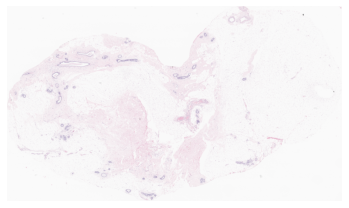

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning:

divide by zero encountered in log

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning:

invalid value encountered in log



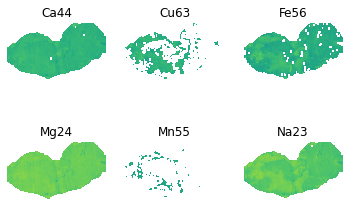

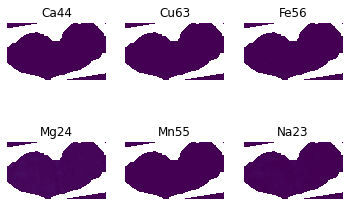

In [7]:
df_co = {'image': [], 'element': [],}
# metal_data['metals']['Ca44']
for one_metal in list(metal_data['metals'].keys()):
    df_co['image'].append(metal_data['metals'][one_metal])
    df_co['element'].append(one_metal)
dfs_new_df_co = pd.DataFrame(df_co)

def crop_slide(whole_svs_array):
    im_large=whole_svs_array
    
    tissue_mask=generate_tissue_mask(im_large*5,compression=32.,threshold=240,kernel=10,gray_before_close=True) 
    compression=32
    
    # Metal image is only portion of slide
#     if (imageId == "092619_007_T_HER2"):    
        
#     if (imageId == "102720_003_T_TNBC"):
#         labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
#         lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
#         xmin,ymin,xmax,ymax=(lbl_table.iloc[1][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
#     else:  
    labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
    lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
    xmin,ymin,xmax,ymax=(lbl_table.iloc[0][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
    
    im_large_crop=im_large[xmin:xmax,ymin:ymax].copy()
    im_large_crop[~tissue_mask[xmin:xmax,ymin:ymax]]=255
    
    return im_large_crop, [[xmin, ymin], [xmax, ymax]], tissue_mask    

def rescale_no_exposure(im_large_crop, metals_im_gray):
    im_large_crop_gray=cv2.cvtColor(im_large_crop,cv2.COLOR_RGB2GRAY) 
    compression_new=max(im_large_crop_gray.shape)/max(metals_im_gray.shape)        
    im_small_crop_gray=cv2.resize(im_large_crop_gray,None,fx=1/compression_new,fy=1/compression_new)
    im_small_crop=cv2.resize(im_large_crop,None,fx=1/compression_new,fy=1/compression_new)
    
    common_size=np.vstack([im_small_crop_gray.shape,metals_im_gray.shape]).max(0)

    im_small_crop_gray_pad=(np.ones(common_size)*np.nan)
    im_small_crop_gray_pad[:im_small_crop_gray.shape[0],:im_small_crop_gray.shape[1]]=im_small_crop_gray
    im_small_crop_gray_pad[np.isnan(im_small_crop_gray_pad)]=255

    metals_im_gray_pad=(np.ones(common_size)*np.nan)
    metals_im_gray_pad[:metals_im_gray.shape[0],:metals_im_gray.shape[1]]=metals_im_gray
    
    padding = common_size - im_small_crop_gray.shape
    
    return im_small_crop, im_small_crop_gray_pad, metals_im_gray_pad, compression_new, padding

def warp_metals(slide_x, slide_y, metals_x, metals_y):
    warped_metals=dict()   
    for _,(element,element_image) in dfs_new_df_co[['element','image']].iterrows():
        h, w = dfs_new_df_co['image'][0].shape
        metal_k_im_gray_pad = element_image

#         slide_x = [1009, 1065, 685, 773, 816, 630, 132, 12]
#         slide_y = [47, 2, 250, 267, 230, 867, 261, 379]
#         metals_x = [1037, 1078, 695, 785, 825, 622, 148, 16]
#         metals_y = [65, 17, 274, 300, 251, 859, 262, 352]
        points_src = []
        points_dst = []
        for i, p in enumerate(slide_x):
            points_dst.append([slide_x[i], slide_y[i]])
            points_src.append([metals_x[i], metals_y[i]])
        points_src = np.array(points_src)
        points_dst = np.array(points_dst)
        homo, status = cv2.findHomography(points_src, points_dst)
        warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (w, h))
    return warped_metals

im_large_crop, minmax, mask = crop_slide(im_large)
metals_im_gray=dfs_new_df_co['image'].mean(0)
im_small_crop, im_small_crop_gray_pad, metals_im_gray_pad, compression_new, padding = rescale_no_exposure(im_large_crop, metals_im_gray)
warped_metals = warp_metals()
#################################
y = dict()
y['xmin'] = minmax[0][0]
y['xmax'] = minmax[1][0]
y['ymin'] = minmax[0][1]
y['ymax'] = minmax[1][1]
x = dict()
x['minmax'] = y
x['metals'] = warped_metals

data = x
# with open(path, 'rb') as f:
#     data = pickle.load(f)
# svs_path = data['svs']
hne_image = im_large[data['minmax']['xmin']:data['minmax']['xmax'], data['minmax']['ymin']:data['minmax']['ymax']]
im_small = cv2.resize(hne_image, None, fx=1/15, fy=1/15)
# print(path[98:])
plt.imshow(im_small)
plt.axis("off")
plt.show()

fig, axs = plt.subplots(2, 3)
metal_c = 0
for x in range(2):
    for y in range(3):
        axs[x, y].imshow(np.log(data['metals'][list(data['metals'].keys())[metal_c]])+0.01)
        axs[x, y].set_title(str(list(data['metals'].keys())[metal_c]))
        axs[x, y].axis('off')
        metal_c += 1
plt.show()


fig, axs = plt.subplots(2, 3)
metal_c = 0
for x in range(2):
    for y in range(3):
        axs[x, y].imshow(data['metals'][list(data['metals'].keys())[metal_c]])
        axs[x, y].set_title(str(list(data['metals'].keys())[metal_c]))
        axs[x, y].axis('off')
        metal_c += 1
plt.show()

In [10]:
data['metals']['Ca44'].shape

(871, 1499)

In [14]:
im_small_crop_annotation_tab[:, :1499, :].shape

(871, 1499, 3)

In [12]:
im_small_crop_annotation_tab.shape

(871, 1500, 3)

In [56]:
cmap_jet = plt.cm.get_cmap('jet')
padded_metal_image_co = comp_im
# padded_metal_image_co[padded_metal_image_co <= 0] = 0.000001
# padded_metal_image_co = np.nan_to_num(padded_metal_image_co, nan=0.000001)
# padded_metal_image_co = np.log(padded_metal_image_co)+10
padded_metal_image_normalized_co = (padded_metal_image_co - padded_metal_image_co.min()) / (padded_metal_image_co.max() - padded_metal_image_co.min())
padded_metal_image_rgb_co = cmap_jet(padded_metal_image_normalized_co)
padded_metal_image_rgb_co = padded_metal_image_rgb_co[:, :, :3]
# target_color_to_white_co = padded_metal_image_rgb_co[0, 0, :]
# replacement_color_to_white_co = np.array([1, 1, 1])
# mask_to_white_co = np.all(padded_metal_image_rgb_co == target_color_to_white_co, axis=-1)
# padded_metal_image_rgb_co[mask_to_white_co] = replacement_color_to_white_co


In [17]:
padded_metal_image_rgb_co.shape

(871, 1499, 3)

In [22]:
im_small_gray = cv2.cvtColor(im_small_crop_annotation_tab[:, :1499, :], cv2.COLOR_RGB2GRAY)

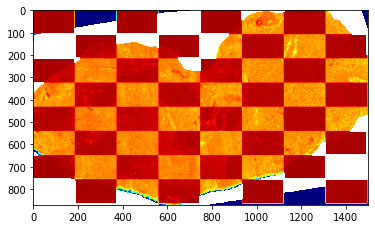

In [51]:
comp_im = compare_images(np.log(im_small_gray*5)+10, np.log(data['metals']['Ca44'])+10, method='checkerboard')
plt.imshow(comp_im, cmap = 'jet')
plt.show()

In [59]:
plt.imshow(cv2.cvtColor(comp_im, cv2.COLOR_GRAY2RGB))

TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [60]:
comp_im.shape

(871, 1499)

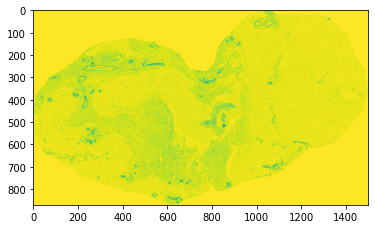

In [24]:
plt.imshow(im_small_gray)

In [25]:
comp_im.shape

(871, 1499)

In [34]:
# mask_resized = cv2.resize(mask[minmax[0][0]:minmax[1][0], minmax[0][1]:minmax[1][1]].astype(np.uint8), None, fx=1/compression_new, fy=1/compression_new)
# metal_mask = (warped_metals['Ca44'] > 0).astype(np.uint8)
# metal_mask = cv2.morphologyEx(cv2.morphologyEx(metal_mask, cv2.MORPH_OPEN, kernel = np.ones((15, 15), np.uint8)), cv2.MORPH_CLOSE, kernel = np.ones((10, 10), np.uint8))
# if padding[0] > 0:
#     metal_mask = metal_mask[:-padding[0], :]
# if padding[1] > 0:
#     metal_mask = metal_mask[:, -padding[1]]
# warped_metals_no_pad = dict()
# for m in warped_metals:    
#     warped_metals_no_pad[m] = warped_metals[m][:metal_mask.shape[0], :metal_mask.shape[1]]

In [30]:
# element_image = dfs_new_df['image'][0]
# h, w = dfs_new_df['image'][0].shape
# metal_k_im_gray_pad=np.ones((h, w))*np.nan
# rotation = cv2.rotate(element_image, cv2.ROTATE_90_CLOCKWISE)
# metal_k_im_gray_pad[:element_image.shape[0], :element_image.shape[1]] = element_image

In [29]:
element_image.shape

(871, 1499)

In [26]:
metal_k_im_gray_pad.shape

(871, 1499)

In [27]:
rotation.shape

(1499, 871)

In [43]:
y = dict()
y['xmin'] = minmax[0][0]
y['xmax'] = minmax[1][0]
y['ymin'] = minmax[0][1]
y['ymax'] = minmax[1][1]
x = dict()
# x['svs'] = i
x['minmax'] = y
x['hne_mask_small'] = mask_resized
x['metals_mask'] = metal_mask
x['metals'] = warped_metals
# x['metals'] = warped_metals_no_pad
# with open(f"test.pkl", "wb") as input_file:
#     pickle.dump(x, input_file)

# print('dumped')

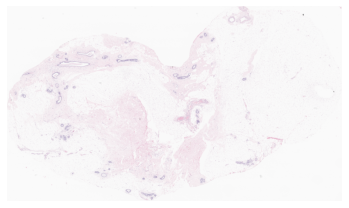

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

divide by zero encountered in log

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in log



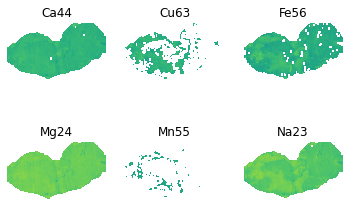

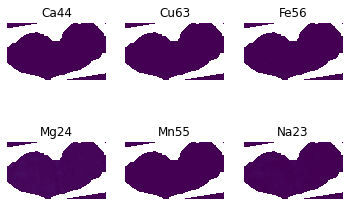

In [44]:
data = x
# with open(path, 'rb') as f:
#     data = pickle.load(f)
# svs_path = data['svs']
hne_image = im_large[data['minmax']['xmin']:data['minmax']['xmax'], data['minmax']['ymin']:data['minmax']['ymax']]
im_small = cv2.resize(hne_image, None, fx=1/15, fy=1/15)
# print(path[98:])
plt.imshow(im_small)
plt.axis("off")
plt.show()

fig, axs = plt.subplots(2, 3)
metal_c = 0
for x in range(2):
    for y in range(3):
        axs[x, y].imshow(np.log(data['metals'][list(data['metals'].keys())[metal_c]])+0.01)
        axs[x, y].set_title(str(list(data['metals'].keys())[metal_c]))
        axs[x, y].axis('off')
        metal_c += 1
plt.show()


fig, axs = plt.subplots(2, 3)
metal_c = 0
for x in range(2):
    for y in range(3):
        axs[x, y].imshow(data['metals'][list(data['metals'].keys())[metal_c]])
        axs[x, y].set_title(str(list(data['metals'].keys())[metal_c]))
        axs[x, y].axis('off')
        metal_c += 1
plt.show()

In [16]:
data['metals']['Ca44'].shape

(1499, 871)

In [39]:
warped_metals=dict()   
for _,(element,element_image) in dfs_new_df[['element','image']].iterrows():
#         h, w = ims_rescaled[imageId]['im_resized'].shape
#         w, h = dfs_new_df['image'][0].shape
    h, w = dfs_new_df['image'][0].shape
#         metal_k_im_gray_pad=np.ones((h, w))*np.nan
#         rotation = cv2.rotate(element_image, cv2.ROTATE_90_CLOCKWISE)
    metal_k_im_gray_pad = element_image

#         if imageId in rotation_list:
#             metal_k_im_gray_pad = cv2.rotate(metal_k_im_gray_pad, cv2.ROTATE_180)

    slide_x = [1009, 1065, 685, 773, 816, 630, 132, 12]
    slide_y = [47, 2, 250, 267, 230, 867, 261, 379]
    metals_x = [1037, 1078, 695, 785, 825, 622, 148, 16]
    metals_y = [65, 17, 274, 300, 251, 859, 262, 352]
    points_src = []
    points_dst = []
    for i, p in enumerate(slide_x):
        points_dst.append([slide_x[i], slide_y[i]])
        points_src.append([metals_x[i], metals_y[i]])
    points_src = np.array(points_src)
    points_dst = np.array(points_dst)
    homo, status = cv2.findHomography(points_src, points_dst)
#         warped_metals[element] = cv2.warpPerspective(metal_k_im_gray_pad, homo, (w, h))
#         warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (h, w))
    warped_metals[element] = cv2.warpPerspective(src = metal_k_im_gray_pad, M = homo, dsize = (w, h))
# return warped_metals

In [40]:
warped_metals['Ca44'].shape

(871, 1499)

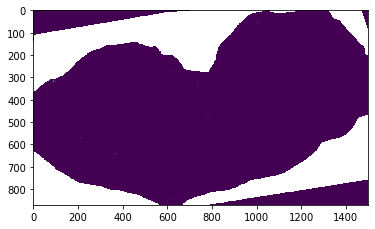

In [41]:
plt.imshow(warped_metals['Ca44'])
plt.show()

In [49]:
app = JupyterDash(__name__, 
                  external_stylesheets=[dbc.themes.SPACELAB], 
                 )

app.layout = html.Div([
    dbc.Button('Show Images', id='show-button', n_clicks=0),
    html.Div(id='image-container', children=[]),
    html.Div(id='image-container_2', children=[], style={'textAlign': 'center'}),
])

@app.callback(
    Output('image-container', 'children'),
    Output('image-container_2', 'children'),
    Input('show-button', 'n_clicks')
)
def show_images(n_clicks):
    if n_clicks > 0:
        image1 = html.Img(src='https://raw.githubusercontent.com/michaelbabyn/plot_data/master/bridge.jpg', style={'width': '50%'})
        image2 = html.Img(src='https://raw.githubusercontent.com/michaelbabyn/plot_data/master/bridge.jpg', style={'width': '50%'})
#         'textAlign': 'center'
        image3 = html.Img(src='https://raw.githubusercontent.com/michaelbabyn/plot_data/master/bridge.jpg', style={'width': '50%'})
          
        return [image1, image2], [image3]
    return [], []

app.run_server(debug=False,
               mode="external",
               host='localhost',
              )




 * Running on http://localhost:8050 (Press CTRL+C to quit)
127.0.0.1 - - [12/Aug/2023 15:58:31] "GET /_alive_3b4fbf7d-a435-4264-a7fd-df8eb227a155 HTTP/1.1" 200 -


Dash app running on http://localhost:8050/


127.0.0.1 - - [12/Aug/2023 15:58:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 15:58:33] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 15:58:33] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 15:58:33] "GET /_favicon.ico?v=2.5.0 HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 15:58:33] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [12/Aug/2023 15:58:34] "POST /_dash-update-component HTTP/1.1" 200 -


In [65]:
app = JupyterDash(__name__, 
                  external_stylesheets=[dbc.themes.SPACELAB], 
                 )
white_image = np.ones((100, 100, 3), dtype=np.uint8) * 255
fig = px.imshow(white_image)

app.layout = html.Div([
    dbc.Button('Show Images', id='show-button', n_clicks=0),
    dcc.Graph(id='image-container', figure = fig),
])

@app.callback(
    Output('image-container', 'figure'),
    Input('show-button', 'n_clicks')
)
def show_images(n_clicks):
    if n_clicks > 0:
        # Generate sample images (replace with your own image data)
        image_data1 = np.random.rand(100, 100)
        image_data2 = np.random.rand(100, 100)
        image_data2 = np.zeros((100, 100))

        fig = px.imshow(comp_im)
#         fig.add_trace(px.imshow(image_data2).data[0])

        return fig
    fig = px.imshow(image_data2)
    return fig

app.run_server(debug=False,
               mode="external",
               host='localhost',
              )



 * Running on http://localhost:8050 (Press CTRL+C to quit)
127.0.0.1 - - [12/Aug/2023 19:39:58] "GET /_alive_aa76a70d-6441-4ec4-a70c-fbe9cf7a7ce3 HTTP/1.1" 200 -


Dash app running on http://localhost:8050/


127.0.0.1 - - [12/Aug/2023 19:40:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 19:40:00] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 19:40:00] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 19:40:00] "GET /_favicon.ico?v=2.5.0 HTTP/1.1" 200 -
127.0.0.1 - - [12/Aug/2023 19:40:00] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 19:40:00] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [12/Aug/2023 19:40:00] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [12/Aug/2023 19:40:04] "POST /_dash-update-component HTTP/1.1" 200 -
